In [86]:
import netket as nk
from numpy.lib.function_base import append
from itertools import permutations, combinations
from netket.vqs.mc import get_local_kernel_arguments, get_local_kernel
import time
import matplotlib.pyplot as plt
import json
import numpy as np
from numpy.linalg import eig
from flax.core.frozen_dict import FrozenDict
import flax
from netket.optimizer.qgt import QGTJacobianPyTree


from typing import Callable, Tuple
from functools import partial

import jax
from jax import numpy as jnp

from netket.stats import statistics as mpi_statistics, mean as mpi_mean, Stats
from netket.utils.types import PyTree
from netket.operator.spin import sigmax, sigmay,sigmaz

import matplotlib.pyplot as plt
from tqdm import tqdm
################################################################
from scipy.sparse.linalg import eigsh
################################################################
import os
import pandas as pd



In [193]:
# We always shorten netket as nk
import netket as nk

# Define a 1d chain
L = 6
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)
# hamiltonian = nk.operator.Heisenberg(hilbert=hi, graph=g)
# hamiltonian = nk.operator.Ising(h=1.321, hilbert=hi, J=0.5, graph=g)
# hamiltonian = sum([ sigmax(hi,i)*sigmax(hi,(i+1)%L)
#                        + sigmay(hi,i)*sigmay(hi,(i+1)%L)
#                        + sigmaz(hi,i)*sigmaz(hi,(i+1)%L)
#                          for i in range(L)])

# 1D Ising
# hamiltonian = sum([sigmaz(hi,i)*sigmaz(hi,(i+1)%L)
#                          for i in range(L)])


# 1D Heisenberg
hamiltonian = sum([ 
                    sigmax(hi,i)*sigmax(hi,(i+1)%L)
                    +sigmay(hi,i)*sigmay(hi,(i+1)%L) #이 녀석이 자꾸 pauli term을 complex로 만든다......
                    +sigmaz(hi,i)*sigmaz(hi,(i+1)%L)
                         for i in range(L)])


Text(0, 0.5, 'E')

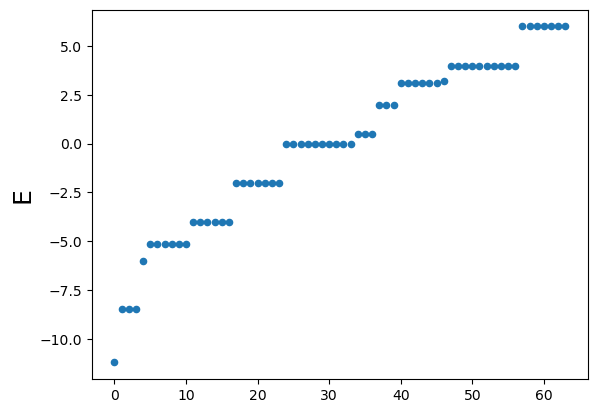

In [225]:
E, vec = np.linalg.eigh(hamiltonian.to_dense())
plt.scatter(np.arange(len(E)),E,s=20)
plt.ylabel('E',fontsize=18)

In [209]:
# todelete
from scipy.sparse.linalg import eigsh
ha = hamiltonian.to_sparse()
e_gs, psi_gs = eigsh(ha, k=10)
# e_gs = e_gs[0]
# psi_gs = psi_gs.reshape(-1)
# e_gs
e_gs

array([-11.21110255,  -8.47213595,  -6.        ,  -5.12310563,
         6.        ,  -8.47213595,  -8.47213595,   6.        ,
        -5.12310563,   6.        ])

The model itself is only a set of instructions on how to initialise the parameters and how to compute the result. 

To initialise the parameters we do the following:

In [195]:
def to_array(model, parameters):
    # begin by generating all configurations in the hilbert space.
    # all_States returns a batch of configurations that is (hi.n_states, N) large.
    all_configurations = hi.all_states()

    # now evaluate the model, and convert to a normalised wavefunction.
    logpsi = model.apply(parameters, all_configurations)
    psi = jnp.exp(logpsi)
    psi = psi / jnp.linalg.norm(psi)
    return psi

### 3.3 Energy
Now, using that function, let's build another one that computes the energy of the mean field state for the given parameters! 
To do that, you can for example convert the hamiltonian to a sparse format and compute the energy

In [196]:
def compute_energy(model, parameters, hamiltonian_sparse):
    psi_gs = to_array(model, parameters)
    return psi_gs.conj().T@(hamiltonian_sparse@psi_gs)

def compute_variance(model, parameters, hamiltonian_sparse):
    psi_gs = to_array(model, parameters)
    variance = psi_gs.conj().T@(hamiltonian_sparse@hamiltonian_sparse@psi_gs) - (psi_gs.conj().T@(hamiltonian_sparse@psi_gs))**2 
    return variance

def compute_energy_vjp(parameters):
    psi_gs = to_array(model, parameters)
    return psi_gs.conj().T@(hamiltonian_jax_sparse@psi_gs)

In [197]:
# and like before, we can jit-compile it!
compute_energy_jit = jax.jit(compute_energy, static_argnames="model")

# and we precompute the sparse-hamiltonian to avoid the overhead of re-computing them all the time
hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()
hamiltonian_sparse = hamiltonian.to_sparse()
hamiltonian_jax_sparse = hamiltonian_jax.to_sparse()

In [198]:
hamiltonian_jax

PauliStringsJax(hilbert=Spin(s=1/2, N=6), n_strings=18, dtype=complex128, dict(operators:weights)=
    XXIIII : (1+0j),
    YYIIII : (1+0j),
    ZZIIII : (1+0j),
    IXXIII : (1+0j),
    IYYIII : (1+0j),
    IZZIII : (1+0j),
    IIXXII : (1+0j),
    IIYYII : (1+0j),
    IIZZII : (1+0j),
    IIIXXI : (1+0j),
    IIIYYI : (1+0j),
    IIIZZI : (1+0j),
    IIIIXX : (1+0j),
    IIIIYY : (1+0j),
    IIIIZZ : (1+0j),
    XIIIIX : (1+0j),
    YIIIIY : (1+0j),
    ZIIIIZ : (1+0j)
)

In [229]:
from functools import partial

# we use partial to directly jit this function. Jitting the top-most will jit everything inside it as well.
@partial(jax.jit, static_argnames='model')
def compute_energy_and_gradient(model, parameters, hamiltonian_sparse):
    grad_fun = jax.value_and_grad(compute_energy, argnums=1, holomorphic=True)
    return grad_fun(model, parameters, hamiltonian_sparse)

def compute_gradient_jacfwd(model, parameters, hamiltonian_sparse):
#     grad_fun = jax.value_and_grad(compute_energy, argnums=1)
    grad_fun = jax.jacfwd(compute_energy, holomorphic=True, argnums=1)(model, parameters, hamiltonian_sparse)
    return grad_fun

In [232]:
gradient[0]

Array(5.99831213-4.7178684e-18j, dtype=complex128)

In [234]:
model = nk.models.RBM(alpha=1, param_dtype=complex)

parameters = model.init(jax.random.PRNGKey(0), np.ones((hi.size, )))
ener = []
# logging: you can (if you want) use netket loggers to avoid writing a lot of boilerplate...
# they accumulate data you throw at them
# logger = nk.logging.RuntimeLog()
from tqdm import tqdm
for i in tqdm(range(10000)):
    # compute energy and gradient
#     energy, gradient = compute_energy_and_gradient(model, parameters, hamiltonian_jax_sparse)
    gradient = compute_gradient_jacfwd(model, parameters, hamiltonian_jax_sparse)
#     ener.append(energy)
    # update parameters
    parameters = jax.tree_map(lambda x,y:x-0.001*y, parameters, gradient)
    
    # log energy: the logger takes a step argument and a dictionary of variables to be logged
#     logger(step=i, item={'Energy':energy})

    
compute_energy(model, parameters, hamiltonian_sparse) 
# plt.plot(np.real(ener))

100%|█████████████████████████████████████| 10000/10000 [02:40<00:00, 62.18it/s]


Array(-1.99472832-1.57131563e-18j, dtype=complex128)

In [227]:
for i in tqdm(range(100)):
    # compute energy and gradient
#     energy, gradient = compute_energy_and_gradient(model, parameters, hamiltonian_jax_sparse)
    _, grad_fun = jax.vjp(compute_energy_vjp, parameters)
    gradient = grad_fun(np.array(1.0,dtype='complex128'))[0]
    # update parameters
    parameters = jax.tree_map(lambda x,y:x-0.01*y, parameters, gradient)

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 52.45it/s]


In [228]:
compute_energy(model, parameters, hamiltonian_sparse)

Array(-1.9962432-4.4056665e-18j, dtype=complex128)

In [ ]:
def compute_gradient(model, parameters, hamiltonian_sparse):
#     grad_fun = jax.value_and_grad(compute_energy, argnums=1)
    grad_fun = jax.jacfwd(compute_energy, holomorphic=True, argnums=1)(model, parameters, hamiltonian_sparse)
    return grad_fun